'''
Author:
        
        PARK, JunHo, junho@ccnets.org

        
        KIM, JoengYoong, jeongyoong@ccnets.org
        
    COPYRIGHT (c) 2024. CCNets. All Rights reserved.
'''

In [1]:
import sys

path_append = "../" # Go up one directory from where you are.
sys.path.append(path_append) 

from tools.setting.ml_params import MLParameters
from tools.setting.data_config import DataConfig
from nn.utils.init import set_random_seed
set_random_seed(0)

c:\Users\junho\anaconda3\envs\torch\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\junho\anaconda3\envs\torch\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
import torch
import torchvision.datasets as dset
from torchvision import transforms
# import albumentations
n_img_sz = 128
attribute_indices = torch.tensor([20, 31]) # Male, Smiling

# Load the CelebA dataset for training. Specify the root directory where the dataset is located
trainset = dset.CelebA(root=path_append + '../data/celeba', split = "train", transform=transforms.Compose([
                            transforms.Resize(n_img_sz), # Transformations include resizing the images to `n_img_sz`
                            transforms.CenterCrop(n_img_sz), # Center cropping to the same size
                            transforms.ToTensor(), # Converting the images to tensors,
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalizing the pixel values to have a mean and standard deviation of 0.5 across all channels.
                        ]), download= False)

testset = dset.CelebA(root=path_append + '../data/celeba', split = "test", transform=transforms.Compose([
                            transforms.Resize(n_img_sz), # Transformations include resizing the images to `n_img_sz`
                            transforms.CenterCrop(n_img_sz), # Center cropping to the same size
                            transforms.ToTensor(), # Converting the images to tensors
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalizing the pixel values to have a mean and standard deviation of 0.5 across all channels.
                        ]), download= False)    


In [3]:
# Custom dataset class for CelebA dataset
class CelebA(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __getitem__(self, index):
        X, y = self.dataset[index] # Get the image and label at the specified index
        y= torch.index_select(y.unsqueeze(0), 1, attribute_indices).squeeze(0) # Select specific attributes(Male, Smiling) for the label using a predefined list of indices
        return X, y # Return the image and the selected attri   butes
    
    def __len__(self):
        return len(self.dataset) # Return the size of the dataset
        
trainset = CelebA(trainset)
testset = CelebA(testset)

In [4]:

data_config = DataConfig(dataset_name = 'celebA', task_type='encoding', obs_shape=[3, 128, 128], label_size=2, \
                        show_image_indices=[737, 1518, 390, 607])

#  Set training configuration from the AlgorithmConfig class, returning them as a Namespace object.
ml_params = MLParameters()
ml_params.core_model_name = 'none' 
ml_params.encoder_model_name = 'stylegan'

first_data = trainset[0]
X, y = first_data

print(f"Input shape: {X.shape}")
print(f"Label shape: {y.shape}")

print(f"Total number of samples in trainset: {len(trainset)}")

Input shape: torch.Size([3, 128, 128])
Label shape: torch.Size([2])
Total number of samples in trainset: 162770


In [5]:
from trainer_hub import TrainerHub

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Initialize the TrainerHub class with the training configuration, data configuration, device, and use_print and use_wandb flags
trainer_hub = TrainerHub(ml_params, data_config, device, use_print=True, use_wandb=False)

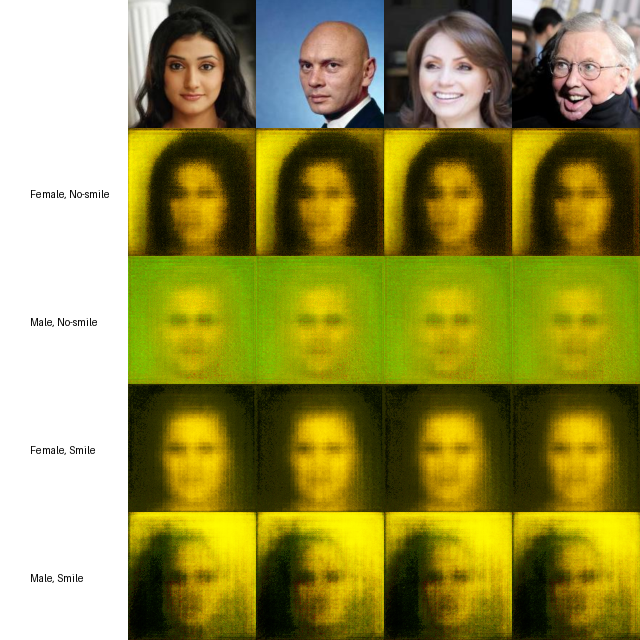

[0/100][550/2543][Time 15.96]
Unified LR across all optimizers: 0.00019672580014116413
--------------------Training Metrics--------------------
Trainer:  stylegan
Inf: 0.4719	Gen: 0.4660	Rec: 0.4272	E: 0.5106	R: 0.4331	P: 0.4214


In [6]:
trainer_hub.train(trainset, testset)    